### CNNs: Classifying cats and dogs

CNNs are  several layers of convolutions with non-linear activation functions, such as ReLU or tanh, applied to the output of the convolutions.

<img src="images/convnets_fig1.png" alt="drawing" width="900"/>

Here we will use CNNs to classify cats and dogs.

You can download the dataset from [here](https://www.dropbox.com/s/j1flrdsbzhmhut8/dogs-vs-cats-small.tar.gz?dl=0). Once downloaded place the file into the dataset directory and untar+unzip it:

```tar xvfz dogs-vs-cats-small.tar.gz```

In [2]:
import keras
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator

## Build the model

We use the sequential API to build a model comprised by 4 convolutional layers and one fully connected layer.

In [3]:
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                            input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model    

In [4]:
model = build_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## Load Data with DataGenerator

We can use `ImageDataGenerator` to load data from directory and apply a series of transformation (i.e. data augmentation) to the images.

In [5]:
train_dir = "datasets/dogs-vs-cats-small/train"
validation_dir = "datasets/dogs-vs-cats-small/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Compile, train and save Model

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=1e-04),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=70,
      validation_data=validation_generator,
      validation_steps=50)

model.save('datasets/dogs-vs-cats-small/dogs_and_cats_small.h5')

Epoch 1/70
100/100 [==============================] - 16s 162ms/step - loss: 0.6957 - acc: 0.5144 - val_loss: 0.6944 - val_acc: 0.4990
Epoch 2/70
100/100 [==============================] - 13s 134ms/step - loss: 0.6910 - acc: 0.5350 - val_loss: 0.6821 - val_acc: 0.5980
Epoch 3/70
100/100 [==============================] - 14s 140ms/step - loss: 0.6846 - acc: 0.5619 - val_loss: 0.6788 - val_acc: 0.5890
Epoch 4/70
100/100 [==============================] - 14s 143ms/step - loss: 0.6774 - acc: 0.5656 - val_loss: 0.6583 - val_acc: 0.5860
Epoch 5/70
100/100 [==============================] - 13s 133ms/step - loss: 0.6611 - acc: 0.5981 - val_loss: 0.6545 - val_acc: 0.5780
Epoch 6/70
100/100 [==============================] - 14s 142ms/step - loss: 0.6473 - acc: 0.6162 - val_loss: 0.6330 - val_acc: 0.6490
Epoch 7/70
100/100 [==============================] - 14s 137ms/step - loss: 0.6332 - acc: 0.6194 - val_loss: 0.6050 - val_acc: 0.6790
Epoch 8/70
100/100 [==============================] - 1

## Visualize History

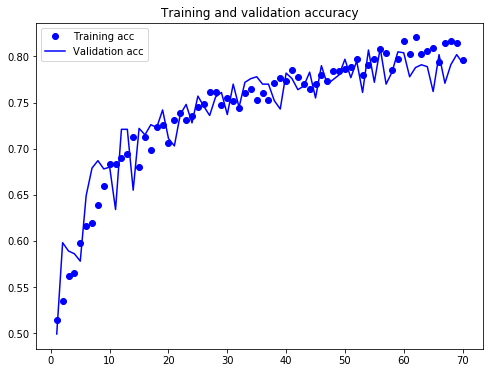

<Figure size 432x288 with 0 Axes>

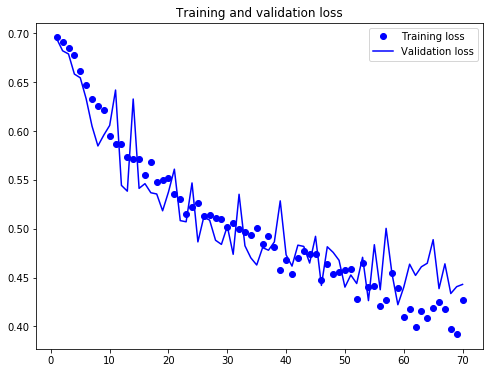

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Fine Tunning. Using pre-trained networks

There are many scenarios where we can used pretrained networks to improve and speed up the process. In other words, we do not need to train a network from stratch and normally leads to better results. 

In this case we will use the VGG16 pretained network without the top layer. This layer will be replaced by our own `FC` which will be fine tunned to our problem. 

In [3]:
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.applications import VGG16

class FCHeadNet:
    @staticmethod
    def build(baseModel, D):
        # we pass a base model which will be pre-trained
        headModel = baseModel.output
        # we add the "head"    
        headModel = Flatten(name= "flatten")(headModel)
        headModel = Dense(D, activation="relu")(headModel)
        headModel = Dropout(0.5)(headModel)
        headModel = Dense(1, activation="sigmoid")(headModel)
        return headModel

## VGG16 + FC layers

In [9]:
baseModel = VGG16(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(150, 150, 3)))
headModel = FCHeadNet.build(baseModel, 256)
model = Model(inputs=baseModel.input, outputs=headModel)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Freeze base layers

`16,812,353` sounds like too much trainable parameters for this particular problem. Let's `freeze` the base layers and and let the `FC` layer warm up to the problem

In [10]:
for layer in baseModel.layers:
    layer.trainable = False

In [11]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Warm Up

We are going to train **just** the head of the network (warm up) and then we will go a bit deeper into the training

In [12]:
train_dir = "datasets/dogs-vs-cats-small/train"
validation_dir = "datasets/dogs-vs-cats-small/validation"

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=25,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/25
100/100 [==============================] - 22s 223ms/step - loss: 0.6890 - acc: 0.5835 - val_loss: 0.5316 - val_acc: 0.7750
Epoch 2/25
100/100 [==============================] - 20s 203ms/step - loss: 0.6023 - acc: 0.6855 - val_loss: 0.4539 - val_acc: 0.8120
Epoch 3/25
100/100 [==============================] - 20s 201ms/step - loss: 0.5126 - acc: 0.7340 - val_loss: 0.3897 - val_acc: 0.8480
Epoch 4/25
100/100 [==============================] - 20s 201ms/step - loss: 0.4877 - acc: 0.7625 - val_loss: 0.3710 - val_acc: 0.8440
Epoch 5/25
100/100 [==============================] - 20s 203ms/step - loss: 0.4447 - acc: 0.8005 - val_loss: 0.3382 - val_acc: 0.8620
Epoch 6/25
100/100 [==============================] - 20s 201ms/step - loss: 0.4371 - acc: 0.7955 - val_loss: 0.3245 - val_acc: 0.8650
Epoch 7/25
100/100 [==============================] - 20s 200ms/step - loss: 0.4306 - acc: 0.8030 - val_loss: 0.3112 - val_acc: 0.8760
Epoch 8/25
100/100 [==============================] - 2

## Run

Now the we have warmed up, let's train a few of the convolutional layers in the base model.

In [14]:
for layer in baseModel.layers[15:]:
    layer.trainable = True
    
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/20
100/100 [==============================] - 24s 237ms/step - loss: 0.3318 - acc: 0.8505 - val_loss: 0.2075 - val_acc: 0.9130
Epoch 2/20
100/100 [==============================] - 23s 226ms/step - loss: 0.2716 - acc: 0.8820 - val_loss: 0.1887 - val_acc: 0.9230
Epoch 3/20
100/100 [==============================] - 23s 227ms/step - loss: 0.2501 - acc: 0.8925 - val_loss: 0.1951 - val_acc: 0.9280
Epoch 4/20
100/100 [==============================] - 23s 227ms/step - loss: 0.2201 - acc: 0.9115 - val_loss: 0.2057 - val_acc: 0.9210
Epoch 5/20
100/100 [==============================] - 23s 227ms/step - loss: 0.1897 - acc: 0.9190 - val_loss: 0.1821 - val_acc: 0.9240
Epoch 6/20
100/100 [==============================] - 23s 227ms/step - loss: 0.1809 - acc: 0.9210 - val_loss: 0.1835 - val_acc: 0.9270
Epoch 7/20
100/100 [==============================] - 23s 229ms/step - loss: 0.1581 - acc: 0.9370 - val_loss: 0.1801 - val_acc: 0.9320
Epoch 8/20
100/100 [==============================] - 2

## Visualize the Conv Layers

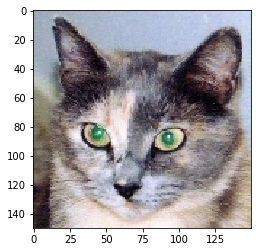

In [15]:
from keras.preprocessing import image 
import numpy as np

img_path = 'datasets/dogs-vs-cats-small/test/cats/cat.1700.jpg'

img = image.load_img(img_path, target_size=(150, 150)) 
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [16]:
from keras.models import load_model

model = load_model('datasets/dogs-vs-cats-small/dogs_and_cats_small.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

We will build a model that will return the outputs of the first 8 layers. 

In [17]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

Let's have a look to the activations of the 4th filter in the first convolutional layer

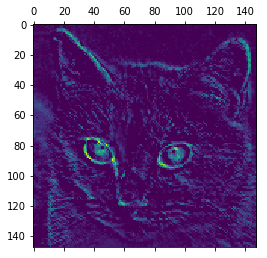

In [18]:
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [19]:
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)
layer_names

['conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3']

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


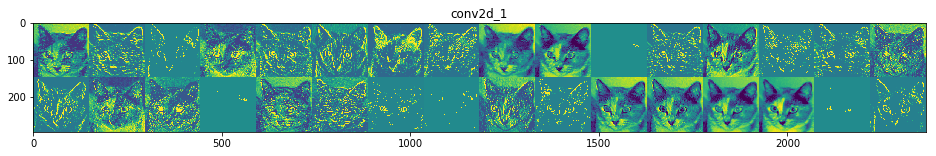

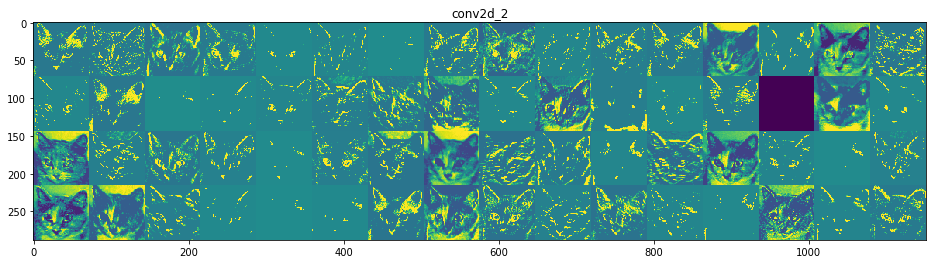

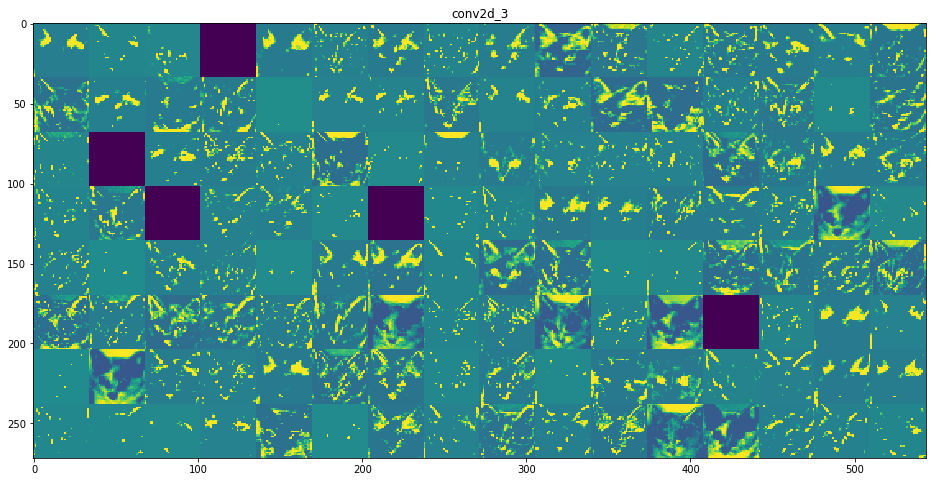

In [20]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if 'conv2d_' in layer_name:
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
    else:
        continue